# Laboratory LCA of Hydrothermal Carbonization  
This Jupyter notebook is for conducting an explaratory life cycle accessment (LCA) analysis to identify areas of sensitivity and further determine the optimal conditions for upscaling hydrothermal carbonization (HTC) under deep uncertainty. This notebook is organized in three sections: 
1) Project Setup: Importing main packages & ecoinvent databases 
2) Baseline LCA Model: Developing a baseline LCA model for evaluating environmental impacts, in the form of carbon,  for basic scenarios. 
3) Uncertainty Analysis: Performing a Monte Carlo simulation as a method of exploring optimal conditions for HTC to consider upon upscaling & futrue decision making, in consideration of lab-scale data uncertainty, utilizing a deterministic model.  

This notebook serves as a supplementary analysis to ____

## 1: Project Setup
Installing required packages, setting up projects, and importing ecoinvent databases. Be sure to activate the virtual environment and install requirements.txt.  

In [1]:
# Installing main packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

In [2]:
# Importing BW2 packages
import brightway2 as bw
from bw2data.parameters import ProjectParameter, ParameterManager, ActivityParameter

In [4]:
# Import BW25 packages. 
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

In [5]:
# Creating a new project: HTC-uncertainty 
bd.projects.set_current('HTC-uncertainty')

Applying automatic update: 4.0 migrations filename change
Applying automatic update: 4.0 new processed format
Updating all LCIA methods


762it [04:14,  2.99it/s]


Updating all LCI databases


1it [00:00, 29.40it/s]


In [6]:
# Installing biosphere flows 
bi.bw2setup()

Creating default biosphere



Writing activities to SQLite3 database:


Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.01 seconds


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/24/2024 16:29:02
  Finished: 07/24/2024 16:29:02
  Total time elapsed: 00:00:00
  CPU %: 31.00
  Memory %: 1.27
Created database: biosphere3
Creating default LCIA methods

Wrote 762 LCIA methods with 227223 characterization factors
Creating core data migrations



In [8]:
# Getting main folder with ecoinvent files. Replace this with your own directory.  
def get_ecoinvent_directory(): 
    return "../../ecoinvent_v3.10"

In [9]:
def write_data(ei_path, ei_name): 
    if ei_name in bd.databases:
        print("Database has already been imported.")
    else:
        ei_importer = bi.SingleOutputEcospold2Importer(ei_path, ei_name, use_mp = False)
        # Should you have a problem with "unlinked exchanges"
        try: 
            ei_importer.add_unlinked_flows_to_biosphere_database() 
        except Exception as e:
            print(f"An error occurred: {e}")
        ei_importer.apply_strategies()
        ei_importer.statistics()
        ei_importer.write_database()
        print(str(ei_name) + " database is completed!")

In [10]:
def create_databases():
    for folder in os.listdir(get_ecoinvent_directory()):
        folder_path = os.path.join(get_ecoinvent_directory(), folder + "/datasets")
        # Only using cutoff for this analysis 
        if os.path.isdir(folder_path) and 'cutoff' in folder:
            write_data(folder_path, folder_path.split('\\')[-1])
    print(bd.databases)

In [11]:
create_databases()

100%|██████████| 23523/23523 [21:53<00:00, 17.90it/s]  


Extracted 23523 datasets in 1320.81 seconds


100%|██████████| 5769/5769 [00:00<00:00, 7902.67it/s] 


Vacuuming database 
Applying strategy: link_iterable_by_fields
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying strategy: fix_unreasonably_high_lognormal_uncertainties
Applying strategy: convert_activity_pa

100%|██████████| 23523/23523 [03:05<00:00, 126.51it/s]


Vacuuming database 
Created database: cutoff/datasets
cutoff/datasets database is completed!
Databases dictionary with 2 object(s):
	biosphere3
	cutoff/datasets


In [12]:
# Ensuring cutoff database has been imported correctly
bd.databases

Databases dictionary with 2 object(s):
	biosphere3
	cutoff/datasets

In [13]:
# Creating database reference to not override or intefere with cutoff model: 
eidb = bd.Database("cutoff/datasets")

In [14]:
# Creating database reference to not override or intefere with the biosphere model: 
biosphere3 = bw.Database('biosphere3')

In [15]:
# Checking for proper replication: 
print("The imported ecoinvent database is of type {} and has a length of {}.".format(type(eidb), len(eidb)))

The imported ecoinvent database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 23523.


In [16]:
# Checking for proper replication of biosphere database 
print("The biosphere database is of type {} and has a length of {}.".format(type(biosphere3), len(biosphere3)))

The biosphere database is of type <class 'bw2data.backends.base.SQLiteBackend'> and has a length of 5769.


In [18]:
# If needed, migrate the project to Brightway2.5
bd.projects.migrate_project_25()

Updating all LCIA methods


762it [03:05,  4.11it/s]


Updating all LCI databases


2it [00:35, 17.64s/it]


In [19]:
# Ensure that LCIA is working as intended. This code snippet should yield the following result: 
# The market group for electricity, low voltage process accounts for 0.494706 kg CO2-Eq.

act = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
functional_unit = { act: 1}
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
lca = bw.LCA(functional_unit, method_key)
lca.lci()
lca.lcia()
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
))

The market group for electricity, low voltage process accounts for 0.494706 kg CO2-Eq.


In [20]:
# Now that the project returns the proper results, backup the project directory
bi.backup.backup_project_directory(
    project='HTC-uncertainty',
    dir_backup='../project-data/lab-HTC'
)

Creating project backup archive - this could take a few minutes...
Saved to: ..\project-data\lab-HTC\brightway2-project-HTC-uncertainty-backup24-July-2024-05-36PM.tar.gz


WindowsPath('../project-data/lab-HTC/brightway2-project-HTC-uncertainty-backup24-July-2024-05-36PM.tar.gz')

## 2: Baseline LCA
Conducting a baseline LCA, as a foreground system for determining environmental impacts for main feedstocks based on numerical averages. The feedstocks of interest are as follows:  
 - SRU Feedstock with water to reach an 85% moisture content
 - BSG Feedstock with water to reach at 85% moisture content
 - DCW Feedstock (already above 85% moisture content; no additional water needed)

### 2.1: Identifying Appropriate Flows
All hydrothermal carbonization models have the following inputs: 
1) Feedstock: It will be assumed that the feedstock is a waste product and has no corresponding environmental impacts. The process of transporting food waste is not considered for this analysis.  
2) Water: If needed, water is added to reach a moisture content. If not needed, water is 0. 
3) Electricity: Needed for stirring of an HTC reaction & for post-processing. 
4) Heat: Needed for the HTC reaction and post-processing steps. 
It will be assumed that the equipment itself has a long lifetime and any pre-processing for the equipment or environmental impacts for setting up or maintaining a system will not be explored in this analysis. 

Simultaneously, all hydrothermal carbonization models have the following outputs: 
1. Hydrochar (functional unit): The goal of this analysis is to determine the optimal method for producing a solid hydrochar (HC).  
2. Carbon Dioxde: Gas yields from HTC are assumed to be pure CO<sub>2</sub> are emitted to the atmosphere. 
3. Wastewater: Process Water from the HTC process that requires treatment at a wastewater treatment plant. 

In [17]:
# Searching for Electricity
for act in [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']]:
    print(act)

'market group for electricity, low voltage' (kilowatt hour, US, None)


In [14]:
# Assuming Heat uses the same source as electricity, based on Parr reactor specifications
# https://www.parrinst.com/products/stirred-reactors/series-4520-1-2l-bench-top-reactors/specifications/

for act in [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']]:
    print(act)

'market group for electricity, low voltage' (kilowatt hour, US, None)


In [15]:
# Searching for Water 
for act in [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']]:
    print(act)

'market for water, completely softened' (kilogram, US, None)


In [16]:
# Searching for Wastewater 
for act in [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']]:
    print(act)

'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)


In [17]:
# Searching for Carbon Dioxide Stream; in this case the second option is of interest.  
for flow in [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()]:
    print(flow)

'Carbon dioxide, non-fossil, resource correction' (kg, None, None)
'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air'))


### 2.2: Setting Up Product System
Creating product systems for main feedstocks

In [18]:
from feedstock import Feedstock, FeedstockManager, create_elementary_feedstocks
from model import get_feedstock_quantity, get_water_quantity, get_heat_needed, get_electricity_needed
from model import  get_co2_emissions, get_pw, get_parameter, get_post_processing

In [19]:
# If needed, delete existing parameters
for item in ProjectParameter.select(): 
    item.delete()

ProjectParameter.drop_table(safe=True, drop_sequences=True)
# create a new empty table of project parameters
ProjectParameter.create_table()

for name in ProjectParameter.select():
    name.print()

In [20]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)

In [21]:
# Re initializing elementary feedstocks if needed
elementary_feedstocks = create_elementary_feedstocks()

In [22]:
def create_hydrochar_activity(feedstock: Feedstock):
    '''Creates a hydrochar activity, given a feedstock'''
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}_{temp}C_{time}hr',
        name=f"hydrochar production, {feedstock.name}_{temp}C_{time}hr",
        location='US',
        unit="kg"
    )
    parameters = ParameterManager()
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr', 
            'amount': get_post_processing(hc_placeholder=1)
        }
    ]
    
    print(project_data)
    parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}_{temp}C_{time}hr/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}_{temp}C_{time}hr').save()
    hydrochar_production.save()
    
    parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr")
    print()        

In [23]:
# Creating Activities for Different Feedstocks 
excluded_feedstocks = {"rawSRU", "rawBSG"}
for attr, feedstocks in elementary_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        if feedstock.name not in excluded_feedstocks:
            create_hydrochar_activity(feedstock)

[{'name': 'feedstock_HTC_stdSRU_190C_1hr', 'amount': 4.405149378057423}, {'name': 'water_HTC_stdSRU_190C_1hr', 'amount': 1.4013095047525619}, {'name': 'heat_HTC_stdSRU_190C_1hr', 'amount': 1.802243989661737}, {'name': 'electricity_HTC_stdSRU_190C_1hr', 'amount': 0.052881176818981995}, {'name': 'co2_HTC_stdSRU_190C_1hr', 'amount': 0.013643627895201066}, {'name': 'wastewater_HTC_stdSRU_190C_1hr', 'amount': 4.792815254914784}, {'name': 'post_processing_HTC_stdSRU_190C_1hr', 'amount': 28.815}]

[{'name': 'feedstock_HTC_stdSRU_190C_3hr', 'amount': 3.902283644770988}, {'name': 'water_HTC_stdSRU_190C_3hr', 'amount': 1.2413443205572885}, {'name': 'heat_HTC_stdSRU_190C_3hr', 'amount': 3.9700552622566088}, {'name': 'electricity_HTC_stdSRU_190C_3hr', 'amount': 0.12378628909107907}, {'name': 'co2_HTC_stdSRU_190C_3hr', 'amount': 0.019413962826294342}, {'name': 'wastewater_HTC_stdSRU_190C_3hr', 'amount': 4.124214002501982}, {'name': 'post_processing_HTC_stdSRU_190C_3hr', 'amount': 28.815}]

[{'name'

In [24]:
# Cross Checking Exchanges 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    print(act)
    for exc in act.exchanges():
        print(exc)
    print()

'hydrochar production, stdSRU_220C_1hr' (kg, US, None)
Exchange: 1.1854142947490336 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, stdSRU_220C_1hr' (kg, US, None)>
Exchange: 0.05289386511539747 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, stdSRU_220C_1hr' (kg, US, None)>
Exchange: 2.0065422780511994 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, stdSRU_220C_1hr' (kg, US, None)>
Exchange: -0.025540593899685816 kilogram 'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air')) to 'hydrochar production, stdSRU_220C_1hr' (kg, US, None)>
Exchange: -0.0038863360031058023 cubic meter 'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None) to 'hydrochar production, stdSRU_220C_1hr' (kg, US, None)>
Exchange: 28.815 kilowatt hour 'market group for electric

### 2.3: Testing Baseline LCIA 
Ensuring that Life Cycle Impact Assessments work with Brightway2.5 for one impact category & one metric. 

In [25]:
method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
activity = [act for act in eidb if 'hydrochar production' in act['name']][5]
functional_unit = { activity:1e-3}

In [26]:
lca = bw.LCA(functional_unit, method_key)

In [27]:
lca.lci()
lca.lcia()

In [28]:
lca.demand

{29301: 0.001}

In [29]:
lca.method

('TRACI v2.1 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [30]:
print("The {} process accounts for {:f} {}.".format(
    list(functional_unit.keys())[0]['name'],
    lca.score,
    bw.methods.get(method_key).get('unit')
    ))

The hydrochar production, rawDCW_220C_1hr process accounts for 0.021416 kg CO2-Eq.


In [31]:
# Note that CO2 is not included, will resolve when computing LCIA for multiple impact categories
exchange_contributions = []
total_impact = lca.score
for exc in activity.exchanges():
    # Create a temporary LCA object for each exchange
    temp_lca = bw.LCA({exc.input: exc['amount']}, method_key)
    print(exc.input)
    if 'Carbon dioxide' in str(exc.input): 
        pass
    else: 
        temp_lca.lci()
        temp_lca.lcia()
        
        # Calculate the contribution of this exchange
        contribution = temp_lca.score
        
        # Store the result
        exchange_contributions.append({
            'exchange': exc,
            'contribution': contribution,
            'percentage': (contribution * 0.001 / total_impact) * 100
        })

# Print the results
for result in exchange_contributions:
    print(f"Exchange: {result['exchange']}")
    print(f"Contribution: {result['contribution']:.4f}")
    print(f"Percentage of total impact: {result['percentage']:.2f}%")
    print('-' * 40)

'market for water, completely softened' (kilogram, US, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
'Carbon dioxide, non-fossil, resource correction' (kilogram, None, ('natural resource', 'in air'))
'treatment of wastewater, average, wastewater treatment' (cubic meter, RoW, None)
'market group for electricity, low voltage' (kilowatt hour, US, None)
Exchange: Exchange: 0.0 kilogram 'market for water, completely softened' (kilogram, US, None) to 'hydrochar production, rawDCW_220C_1hr' (kg, US, None)>
Contribution: 0.0000
Percentage of total impact: 0.00%
----------------------------------------
Exchange: Exchange: 0.42538973670885977 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, US, None) to 'hydrochar production, rawDCW_220C_1hr' (kg, US, None)>
Contribution: 0.2104
Percentage of total impact: 0.98%
----------------------------------------
Exchange: Exchange: 

### 2.4: Developing Baseline LCA Models & Saving Data
Given that the baseline LCIA model has worked for one category for one process of producing hydrochar, repeat the process for all of the different baseline models and save to an Excel worksheet. 

In [32]:
# Identifying Life Cycle Impact Assessment Methods of Interest
methods = []
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'water use' in str(m)][0])
methods.append([m for m in bw.methods if 'ReCiPe 2016 v1.03, midpoint (H)' in str(m) and 'no LT' in str(m) and 'energy resources' in str(m)][0])
for method in [m for m in bw.methods if 'TRACI' in str(m) and 'no LT' in str(m)]: 
    methods.append(method)

In [33]:
from lcia import HydrocharLCIA, HydrocharLCIAManager

In [34]:
def get_impact_category(method) -> str:
    '''Returns the corresponding impact assessment method name for modifying HydrocharLCIA given a Brightway LCIA method''' 
    if 'energy resource' in method[1]:
        return 'energy_resources'
    elif 'non-carcinogenic' in method[1]:
        return 'human_toxicity_noncarcinogenic'
    else: 
        method_name = (method[1].split('no LT')[0]).rstrip().replace(':', '_')
        method_name  = method_name.replace(' ', '_')
        method_name  = method_name.replace('__', '_')
        return method_name

In [35]:
# Creating a baseline lcia manager for storing results from hydrochar production
baseline_lcia_manager = HydrocharLCIAManager()

In [36]:
# Functional Unit: 1g or 0.001kg
scaling_factor = 0.001 
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Computing LCIA for different process categories for all baseline LCIA results 
for act in [act for act in eidb if 'hydrochar production' in act['name']]:
    activity_lcia = HydrocharLCIA(act['name'])
    for method in methods:
        impact_category = get_impact_category(method)
        method_key = method
        unit = bw.methods.get(method_key).get('unit')
        
        for i in range(len(process_categories)):
            process_catgeory = process_categories[i]
            exc = [exc for exc in act.exchanges()][i]
                
            functional_amount = exc['amount'] * scaling_factor
            functional_unit = { exc.input: functional_amount}
            temp_lca = bw.LCA(functional_unit, method_key)
            
            if 'Carbon dioxide' in str(exc.input) and 'climate change' in str(method_key):
                activity_lcia.set_impact_score(impact_category, process_catgeory, -1*functional_amount, unit)
                
            elif 'Carbon dioxide' in str(exc.input):
                activity_lcia.set_impact_score(impact_category, process_catgeory, 0, unit)
            
            else:
                temp_lca.lci()
                temp_lca.lcia()
                # print(exc.input, str(temp_lca.score) + str(unit))
                activity_lcia.set_impact_score(impact_category, process_catgeory, temp_lca.score, unit)
    
    baseline_lcia_manager.add_hydrochar(activity_lcia)
    print(activity_lcia.name , "successfully calculated & added to baseline LCIA Manager.")
    

hydrochar production, rawDCW_250C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_220C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_190C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully calculated & added to baseline LCIA Manager.
hydrochar production, stdSRU_190C_3hr su

In [37]:
def export_hydrochar_lcia_to_excel(baseline_lcia_manager, exchange_names, input_names, file_path):
    
    # Create an Excel writer object with the xlsxwriter engine
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        # Iterate through each hydrochar in the baseline_lcia_manager
        # for attr, lcia in baseline_lcia_manager.__dict__.items():
        hydrochar_lcia_list = sorted([hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia], key=lambda x: x.name)
        for hydrochar in hydrochar_lcia_list:
            # Create a dataframe for the hydrochar LCIA
            sheet_name = hydrochar.name.split('hydrochar production, ')[1]
            data = []

            # Row 1: Two blank cells followed by exchange names
            data.append(['', '', *exchange_names])
            
            # Row 2: Two blank cells followed by input names
            data.append(['', '', *input_names])
            
            # Row 3: First cell filled with 'Impact Assessment Method'
            data.append(['Impact Assessment Method'])
            
            # Fill other rows with impact assessment data
            impact_categories = [
                'water_use', 'energy_resources', 'acidification', 'climate_change',
                'ecotoxicity_freshwater', 'eutrophication', 'human_toxicity_carcinogenic',
                'human_toxicity_noncarcinogenic', 'ozone_depletion',
                'particulate_matter_formation', 'photochemical_oxidant_formation'
            ]
            
            for category in impact_categories:
                method_name = category.replace('_', ' ').title()
                method_unit = ""
                impact_data = getattr(hydrochar, category)
                for process_category in impact_data:
                    unit = impact_data[process_category]['unit']
                    if unit:
                        method_unit = unit
                        break
                
                row = [method_name, method_unit]
                for process_category in process_categories:
                    row.append(float('{:.2e}'.format(impact_data[process_category]['score'])))
                    # print(process_category)
                    # print(impact_data[process_category])
                data.append(row)
            
            df = pd.DataFrame(data)
            
            # Write dataframe to Excel sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

In [38]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(baseline_lcia_manager, exchange_names, process_categories, 'baseline-lcia/baseline_lcia.xlsx')

### 2.5: Plotting Functional Unit Baseline LCA Results 
Plotting baseline LCA results standardized to the functional unit of 1 gram of hydrochar produced. 

In [39]:
# Making Figures 
def plot_stacked_bar_impact(baseline_lcia_manager, impact_category, normalization):
    '''
    Plots a stacked bar graph for a Life Cycle Impact Category given a set of LCIA results & normalization technique.
    
    Parameters:
        baseline_lcia_manager (obj: HydrocharLCIAManager): Contains all Hydrochar LCIA results.
        impact_category (str): See method get_impact_categories in class Hydrochar LCIA in lcia.py for available categories.
        normalization (str): Normalization method (i.e. gram hydrochar, 0.5 kg feedstock, gram hydrochar HHV).
    '''
    # Extract all HydrocharLCIA objects from the baseline_lcia_manager
    hydrochar_lcia_list = [hc for attr, lcia in baseline_lcia_manager.__dict__.items() for hc in lcia]

    # Extract labels from the HydrocharLCIA objects
    labels = [hc.name.split('hydrochar production, ')[1] for hc in hydrochar_lcia_list]

    # Prepare data for the plot
    process_categories = ['Water', 'Heat-HTC', 'Electricity - HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    data = {process: [] for process in process_categories}
    units = None

    for hc in hydrochar_lcia_list:
        impact_data = getattr(hc, impact_category)
        for process in process_categories:
            score = impact_data[process]['score']
            unit = impact_data[process]['unit']
            data[process].append(score)
            if not units:
                units = unit

    # Convert data to a NumPy array for easier manipulation
    data_matrix = np.array([data[process] for process in process_categories])

    # Sort labels and data_matrix together based on the labels
    labels, data_matrix = zip(*sorted(zip(labels, data_matrix.T), key=lambda x: x[0]))
    data_matrix = np.array(data_matrix).T

    # Sort the data to have the highest impacts on the bottom
    sorted_indices = np.argsort(data_matrix.sum(axis=1))[::-1]
    sorted_data_matrix = data_matrix[sorted_indices]
    sorted_process_categories = np.array(process_categories)[sorted_indices]

    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 7))
    bottom = np.zeros(len(labels))

    for i, process in enumerate(sorted_process_categories):
        scores = sorted_data_matrix[i]
        ax.bar(labels, scores, bottom=bottom, label=process)
        bottom += scores

    # Adding labels and title
    ax.set_xlabel('Feedstock & Reactor Conditions')
    ax.set_ylabel(f'Total Impact per {normalization} ({units})')
    ax.set_title(f'Total {impact_category.replace("_", " ").title()} Impact')
    ax.legend()

    # Adding total impact labels on the bars in scientific notation
    for i, total in enumerate(bottom):
        formatted_total = f'{total:.1e}'.replace('e-0', 'e-').replace('e+0', 'e')
        ax.text(i, total, f'{formatted_total}', ha='center', va='bottom')

    # Set y-axis to be twice the size of the greatest bar graph value
    ax.set_ylim(0, bottom.max() * 1.5)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

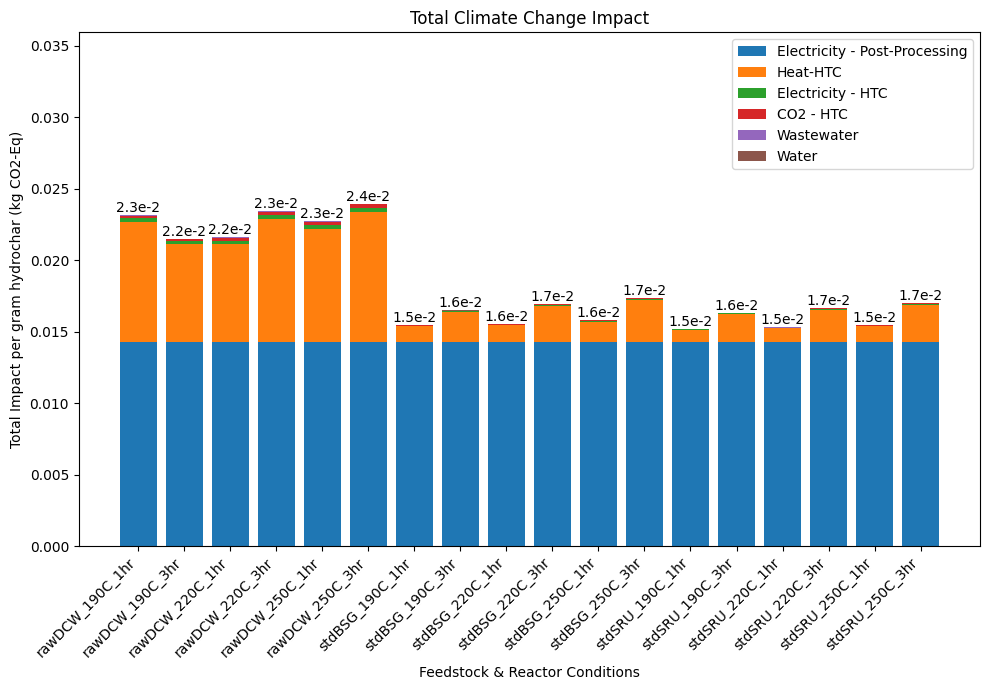

In [40]:
plot_stacked_bar_impact(baseline_lcia_manager, 'climate_change', 'gram hydrochar')

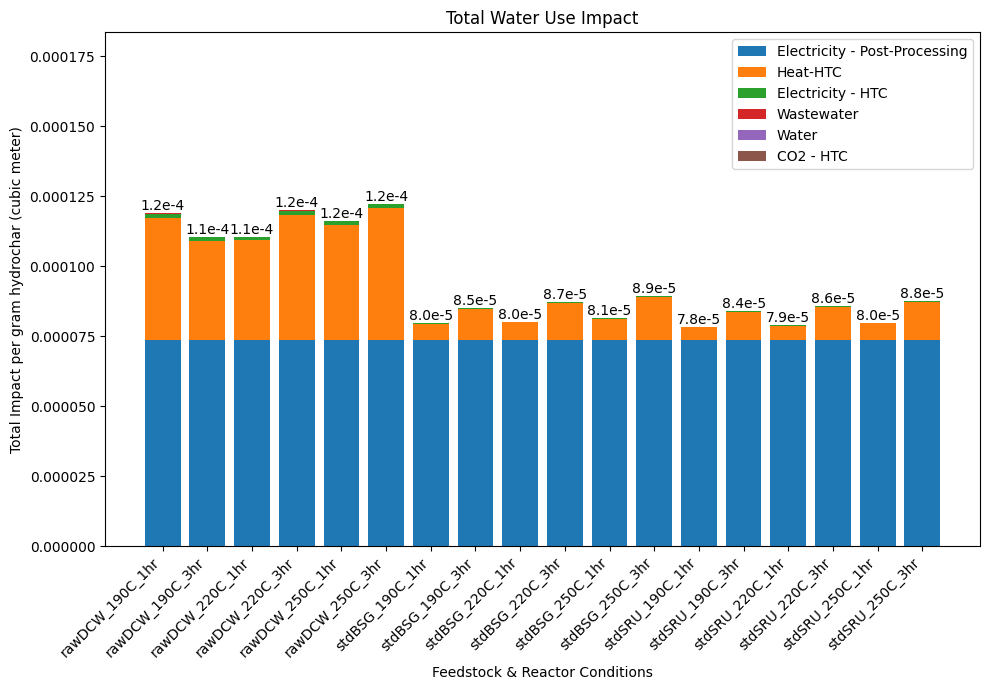

In [41]:
plot_stacked_bar_impact(baseline_lcia_manager, 'water_use', 'gram hydrochar')

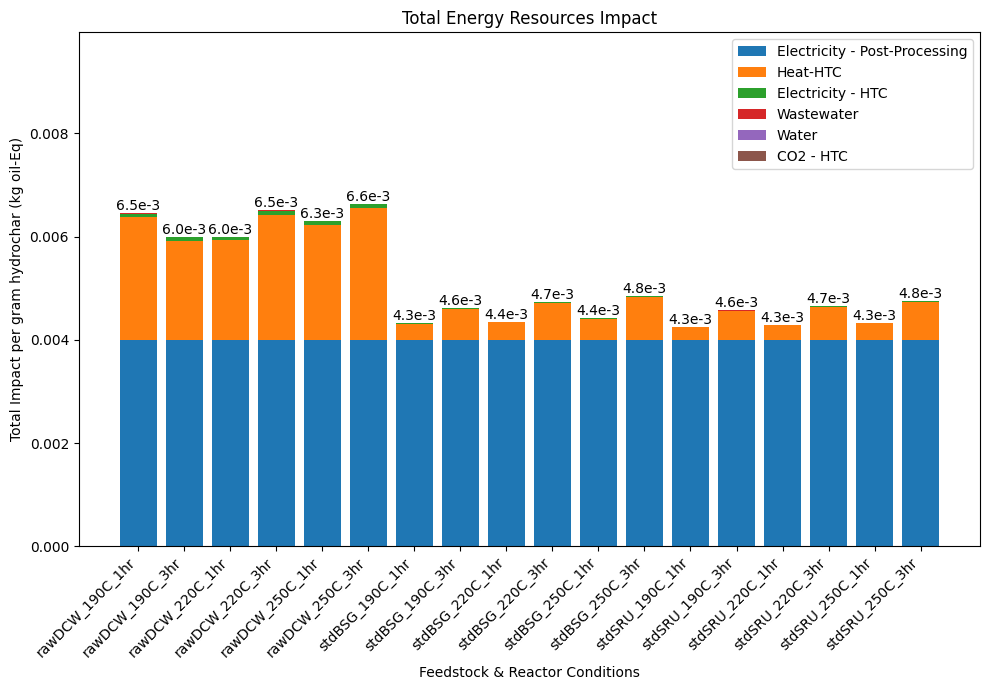

In [42]:
plot_stacked_bar_impact(baseline_lcia_manager, 'energy_resources', 'gram hydrochar')

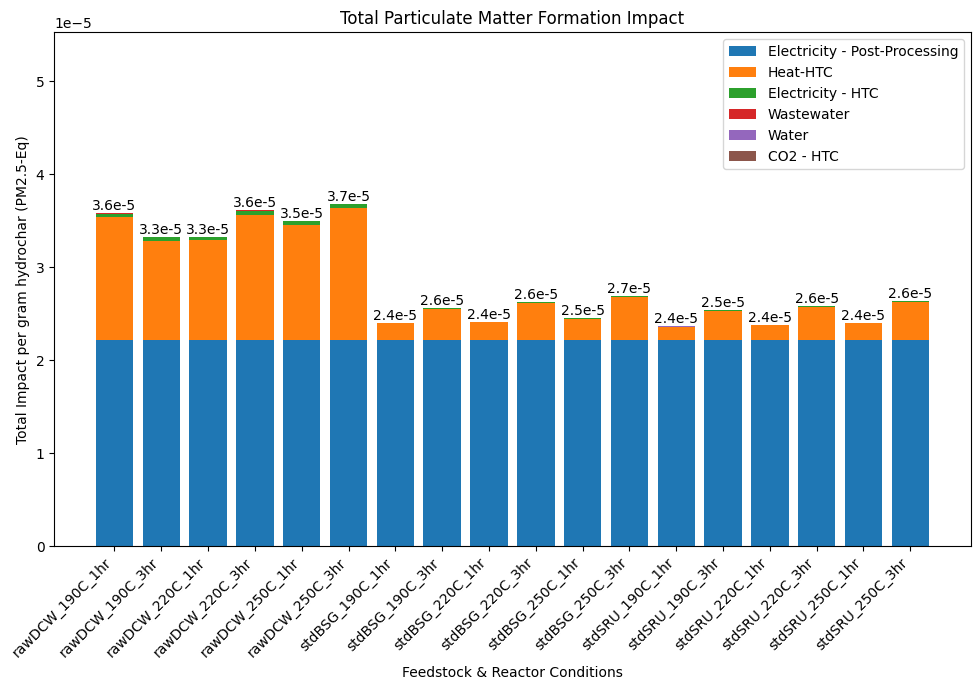

In [43]:
plot_stacked_bar_impact(baseline_lcia_manager, 'particulate_matter_formation', 'gram hydrochar')

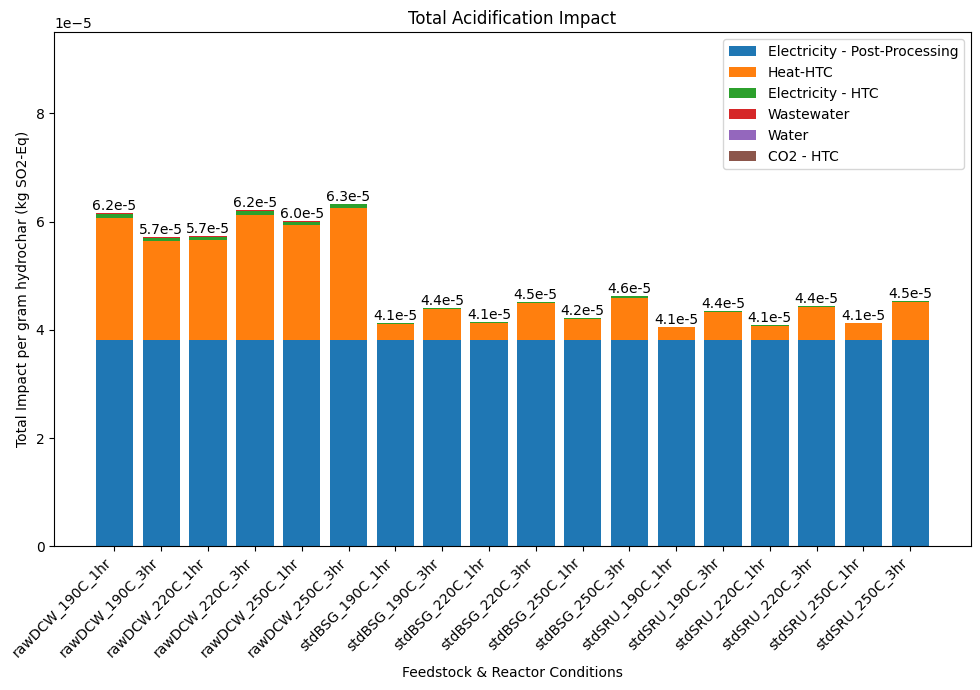

In [44]:
plot_stacked_bar_impact(baseline_lcia_manager, 'acidification', 'gram hydrochar')

### 2.6: Plotting Feedstock Normalized Baseline LCA Results 
Plotting baseline LCA results normalized to per 500 grams of feedstock utilized. Note that difference that appears due to solely utilizing the quantity of the feedstock, as compared to the production of hydrochar. 

In [45]:
# Replicating Baseline LCIA Manager for Re-Use
feedstock_lcia_manager = copy.deepcopy(baseline_lcia_manager)
feedstock_lcia_list = [hc for attr, lcia in feedstock_lcia_manager.__dict__.items() for hc in lcia]
for lcia in feedstock_lcia_list: 
    
    # Getting Relevant Feedstock 
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock_decomposed = activity['name'].split('hydrochar production, ')[1].split('_')
    feedstock_name, temp, time = feedstock_decomposed[0], int(feedstock_decomposed[1][0:3]), int(feedstock_decomposed[2][0])
    
    # Getting Feedstock Quantity 
    feedstock = elementary_feedstocks.get_feedstock(feedstock_name, temp, time)
    
    # Determine normalization factor for getting per feedstock LCIA results
    # LCIA/feedstock = (LCIA / g hydrochar) * (g hydrochar / g feedstock) 
    normalization_factor = 1 / feedstock.quantity
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            # Multiply by 500 to mimic experimental conditions
            unit = lcia.get_impact_unit(impact_category, process_category)
            score = lcia.get_impact_score(impact_category, process_category) * normalization_factor * 500
            lcia.set_impact_score(impact_category, process_category, score, unit)
    
    print(lcia.name , "successfully updated in feedstock LCIA Manager.")

hydrochar production, rawDCW_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_190C_3hr successfully upd

In [46]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(feedstock_lcia_manager, exchange_names, process_categories, 'baseline-lcia/feedstock_lcia.xlsx')

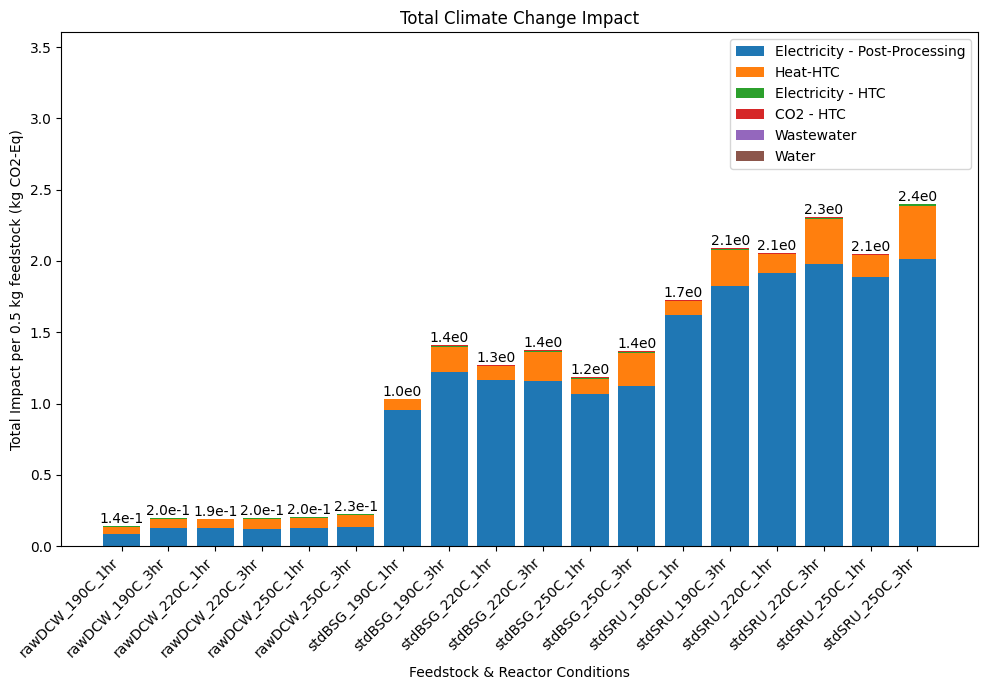

In [47]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'climate_change', '0.5 kg feedstock')

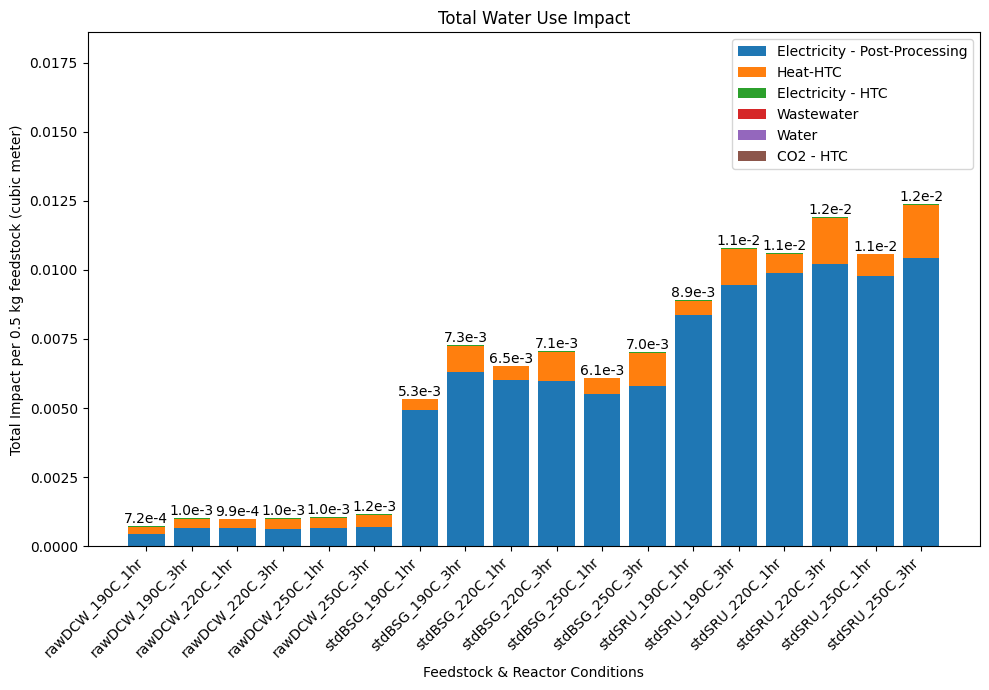

In [48]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'water_use', '0.5 kg feedstock')

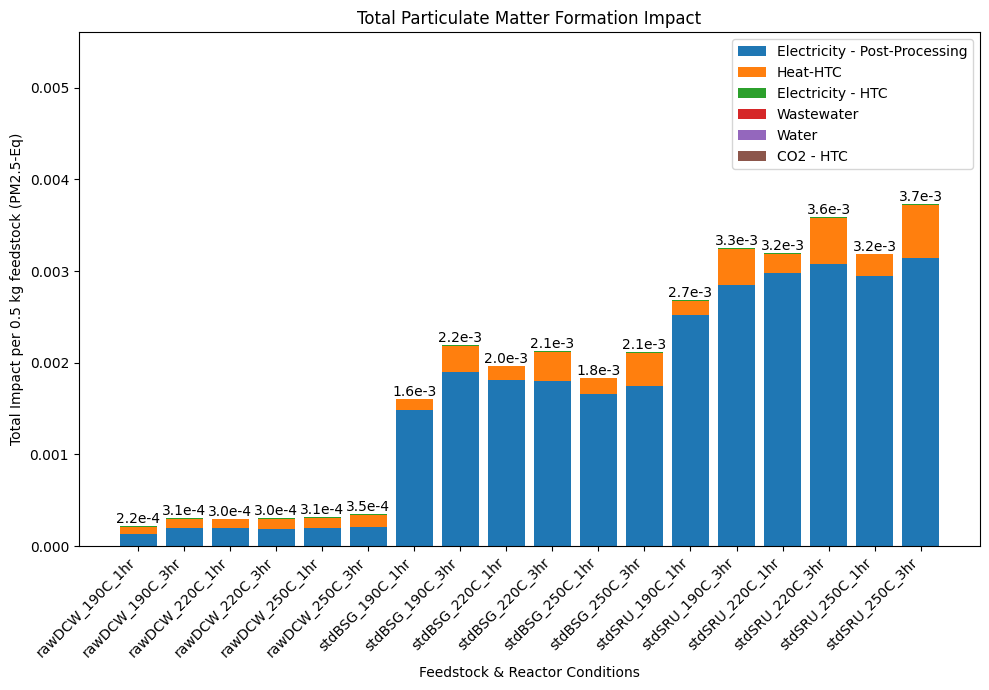

In [49]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'particulate_matter_formation', '0.5 kg feedstock')

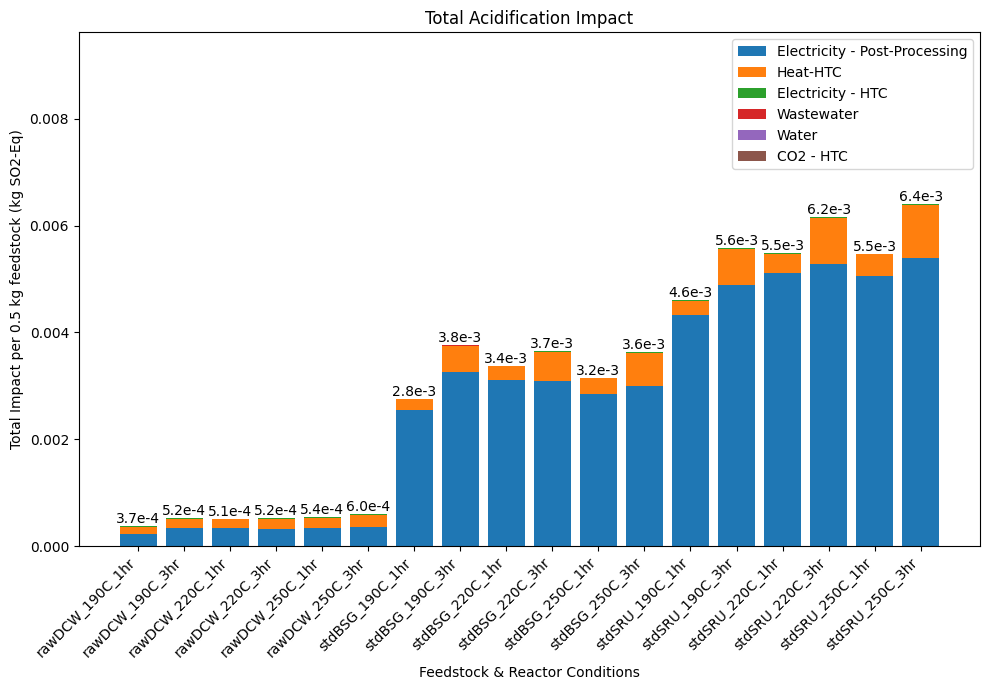

In [50]:
plot_stacked_bar_impact(feedstock_lcia_manager, 'acidification', '0.5 kg feedstock')

### 2.7: Plotting HHV Normalized Baseline LCA Results 
Plotting baseline LCA results normalized to HHV per gram of feedstock utilized. While each process produces a solid hydrochar, the properties of the hydrochar are different, which can affect the best utilization of the hydrochar after production. In this example, we'll focus on a coal replacement for electricity generation through analysis of a higher heating value (HHV). While the downstream process is not in the scope of this analysis and this does not consider the full complexity of post-processing needed for application, it does provide some initial insights towards considering future application.

If considering hydrochar for a different application such as a soil amendment, for carbon sequestration purposes, wastewater treatment, etc, other properties (i.e surface area) may be more applicable. 

In [51]:
# Replicating Baseline LCIA Manager for Re-Use
hc_hhv_lcia_manager = copy.deepcopy(baseline_lcia_manager)
hc_hhv_lcia_list = [hc for attr, lcia in hc_hhv_lcia_manager.__dict__.items() for hc in lcia]
for lcia in hc_hhv_lcia_list: 
    
    # Getting Relevant Feedstock HC HHV
    activity = [act for act in eidb if str(lcia.name) in act['name']][0]
    feedstock = activity['name']
    hc_hhv = get_parameter(feedstock, 'HHV_HC')
    
    # Determine normalization factor for getting per feedstock LCIA results
    # LCIA/feedstock = (LCIA / g hydrochar) / ((MJ / kg hydrochar) * (1/1000) )
    normalization_factor = hc_hhv / 1000
    
    # Alternatively impact_categories = [attr for attr in lcia.__dict__ if attr != 'name']
    impact_categories = lcia.get_impact_categories()
    
    # Alternatively process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']
    process_categories = lcia.get_process_categories()
    
    for impact_category in impact_categories:
        for process_category in process_categories: 
            unit = lcia.get_impact_unit(impact_category, process_category)
            score = lcia.get_impact_score(impact_category, process_category) / normalization_factor 
            lcia.set_impact_score(impact_category, process_category, score, unit)
        
    
    print(lcia.name , "successfully updated in feedstock LCIA Manager.")

hydrochar production, rawDCW_250C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_250C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_1hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, rawDCW_220C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdSRU_190C_3hr successfully updated in feedstock LCIA Manager.
hydrochar production, stdBSG_190C_3hr successfully upd

In [52]:
# Identifying Exchanges of Interest 
exchange_names = []
activity = [act for act in eidb if 'hydrochar production' in act['name']][0]
for exc in activity.exchanges(): 
    exchange_names.append(exc.input)
    
# Gathering Process Categories  
process_categories = ['Water', 'Electricity - HTC', 'Heat-HTC', 'CO2 - HTC', 'Wastewater', 'Electricity - Post-Processing']

# Writing Data to an Excel File 
export_hydrochar_lcia_to_excel(hc_hhv_lcia_manager, exchange_names, process_categories, 'baseline-lcia/hhv_hc_lcia.xlsx')

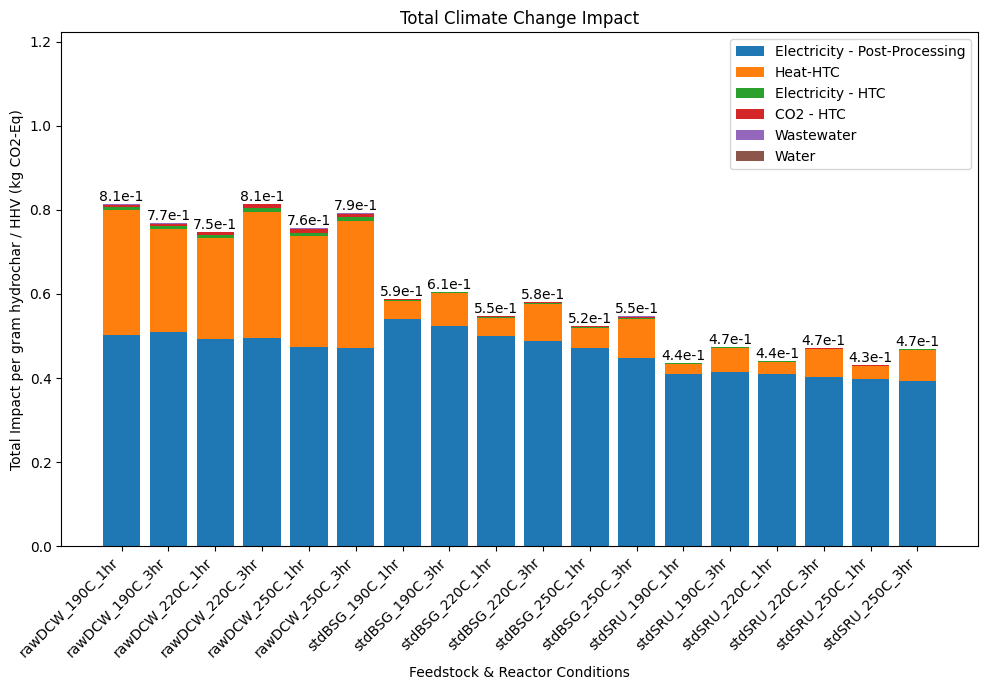

In [53]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'climate_change', 'gram hydrochar / HHV')

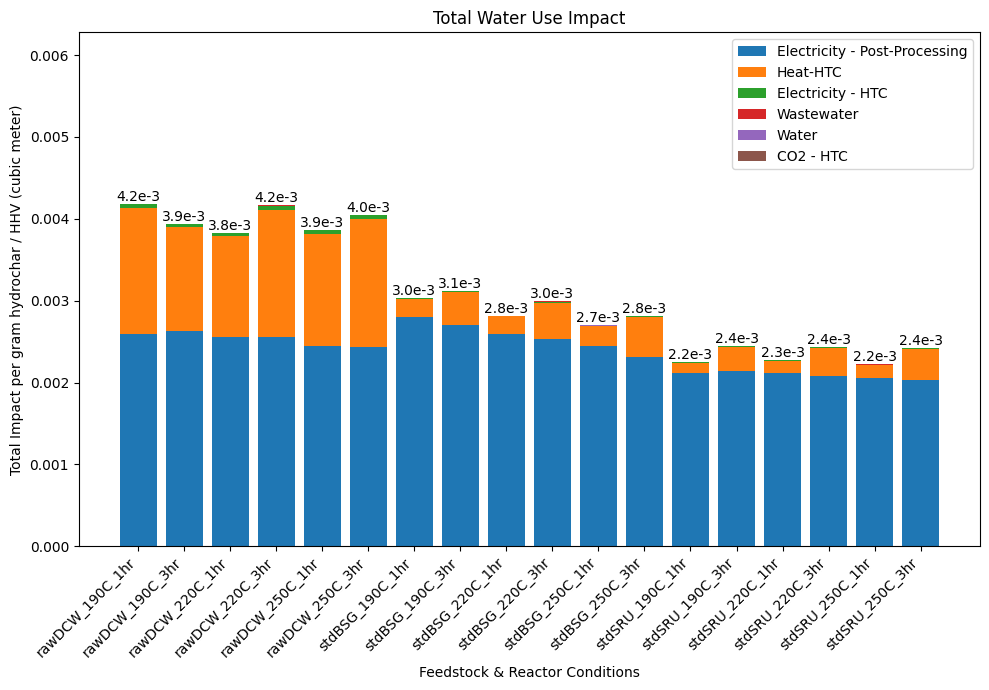

In [54]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'water_use', 'gram hydrochar / HHV')

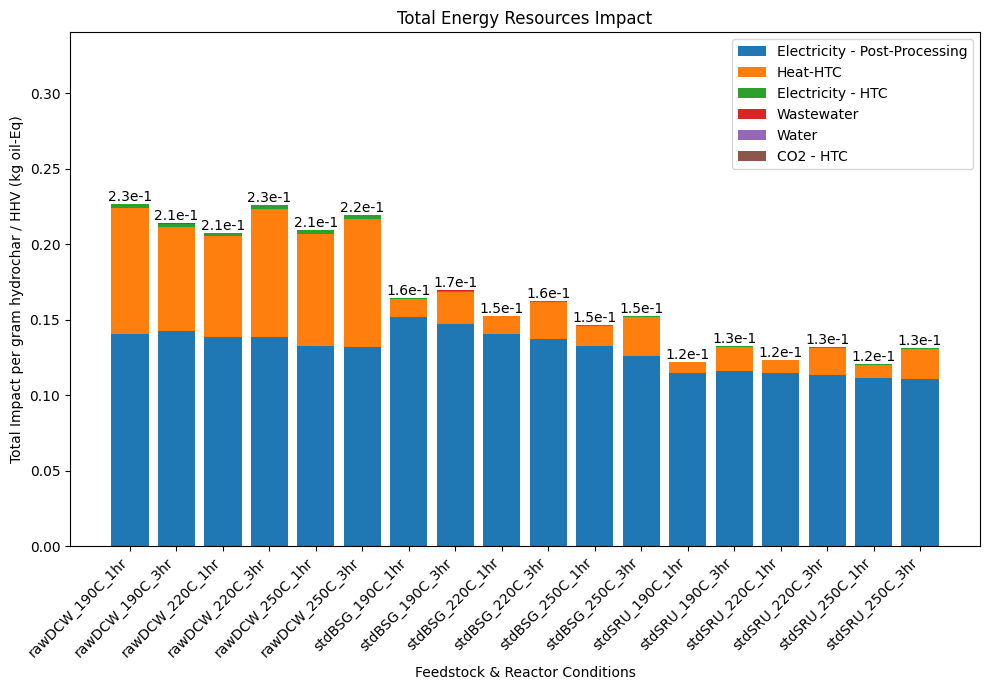

In [55]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'energy_resources', 'gram hydrochar / HHV')

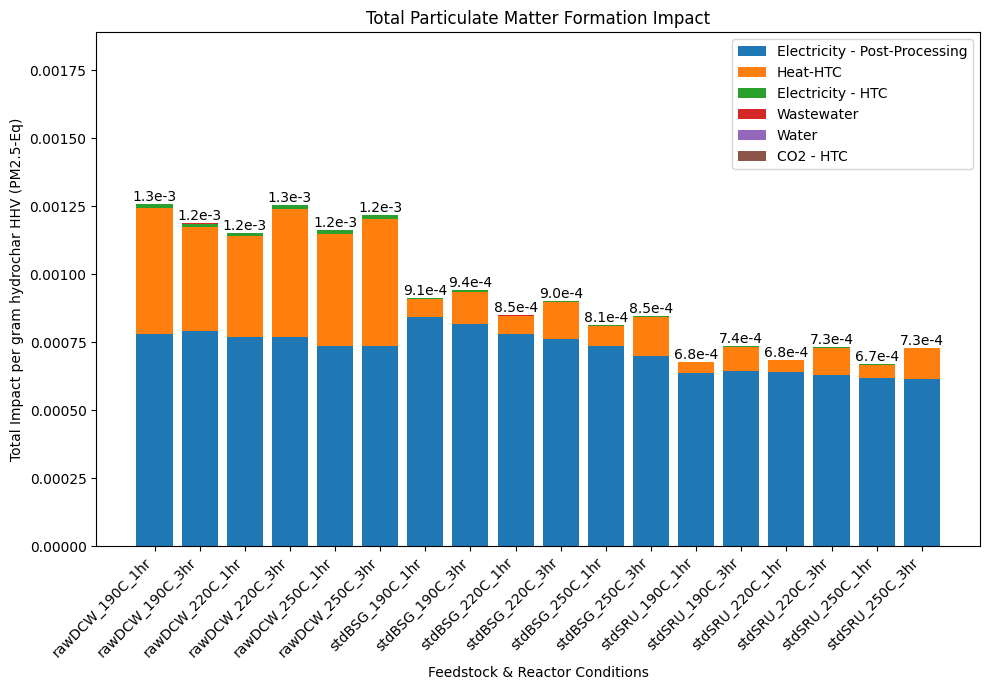

In [56]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'particulate_matter_formation', 'gram hydrochar HHV')

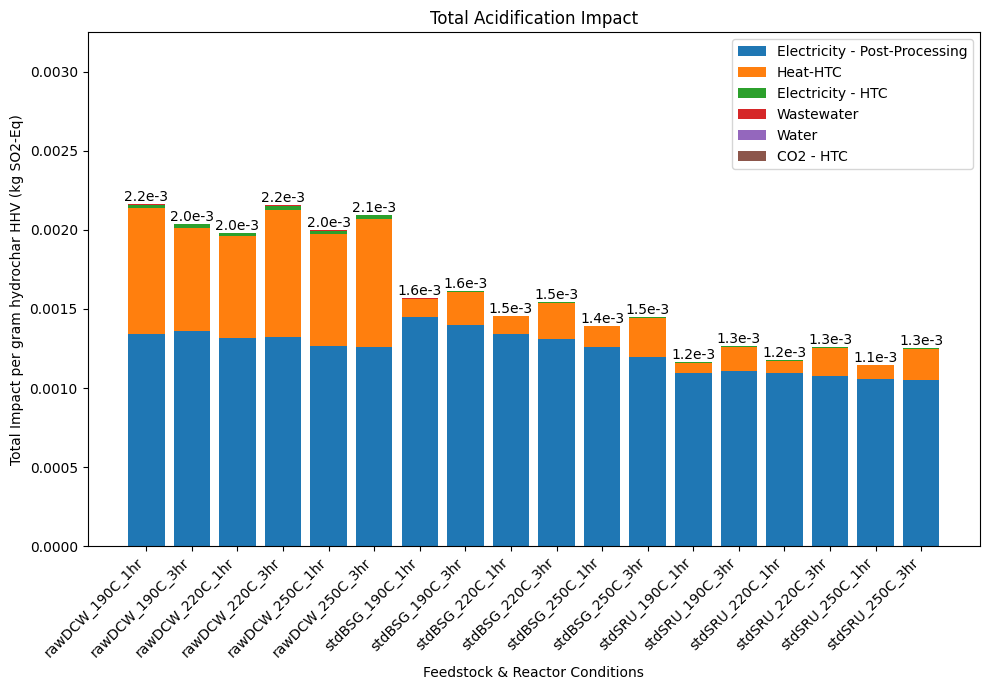

In [57]:
plot_stacked_bar_impact(hc_hhv_lcia_manager, 'acidification', 'gram hydrochar HHV')

## 3: Comprehensive LCA
From the initial LCA baseline models, we can determine that our interpretations rely heavily upon our normalization technique. There are different decisions that can be made based on viewing HTC as a process for managing food waste (standardizing it to a quantity of food waste), a process for producing hydrochar (standardizing it to per quantity of hydrochar produced), or considering the application of hydrochar in a downstream process (in this case, combustion as a substitute for coal). 

While each of these normalization methods can provide value to different stakeholders, it is ultimately important to determine the following: 
1. The most optimal reactor conditions for each feedstock. Specifically, from a temperature and residence time perspective. 
2. The most efficient feedstock (SRU, DCW, BSG) from each of the respective interpretations. 
3. Optimal mixtures or composite feedstocks to upgrade lower value feedstocks. 

<i>"All models are wrong, but some are useful." - George Box</i>. To ensure that this analysis is comprehensively done, Monte Carlo analyses and sensitivity analyses will be used for factoring in uncertainty within experimental & feedstock parameters and corresponding output conditions. As this LCA is done at lab-scale, uncertainties within the impact scores of exchange parameters are not factored into consideration. 

In [58]:
# Creating seed to ensure reproducability 
np.random.seed(1)

In [59]:
# Importing Additional Packages
from tqdm import tqdm
import multiprocessing as mp

### 3.1: Monte Carlo Simulation 
While the LCA model has been developed so that all parameters serve as inputs to obtain corresponding scores for different impact categories, this Monte Carlo simulation is primarily focused on the 'deterministic model' of the HTC process. Although there are uncertainties related to the outputs of HTC— such as hydrochar yield, gas yield, process water yield, and hydrochar characteristics — the primary goal of this Monte Carlo simulation is to examine how variability in feedstock characteristics and reaction conditions influence impact scores. 

This analysis addresses two key goals: (1) determining optimal reactor conditions, and (2) identifying efficient feedstocks. Since the original baseline LCIA results show consistency across all impact categories for the different process categories, the results from one impact category in this analysis are representative of all other indicators. In this case, we will focus on climate change. 

In [60]:
# Creates a feedstock manager to store Monte Carlo feedstocks 
monte_carlo_feedstocks = FeedstockManager()

# Define a set to keep track of feedstock names we've already added
added_feedstock_names = set()

# Creating new original feedstocks 
original_feedstocks = create_elementary_feedstocks()

for attr, feedstocks in original_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        # Select one feedstock of name rawDCW, stdBSG, stdSRU
        if any(feedstock.name.startswith(prefix) for prefix in ['rawDCW', 'stdBSG', 'stdSRU']):
            if feedstock.name not in added_feedstock_names:
                new_feedstock = copy.deepcopy(feedstock)
                new_feedstock.name = new_feedstock.name + '_mc'
                monte_carlo_feedstocks.add_feedstock(new_feedstock)
                added_feedstock_names.add(feedstock.name)

In [61]:
mc_parameters = ParameterManager()

In [62]:
def create_hydrochar_activity_mc(feedstock: Feedstock):
    '''Creates a hydrochar activity for a Monte Carlo simulation, given a feedstock'''
    feedstock.default_mc = feedstock.moisture
    temp = feedstock.temp
    time = feedstock.time 
    hydrochar_production = eidb.new_activity(
        code=f'HTC_{feedstock.name}',
        name=f"hydrochar production, {feedstock.name}",
        location='US',
        unit="kg"
    )
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    project_data = [
        {
            'name': 'feedstock_' + f'HTC_{feedstock.name}', 
            'amount': get_feedstock_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'water_' + f'HTC_{feedstock.name}', 
            'amount': get_water_quantity(yield_HC, feedstock)
        }, 
        {
            'name': 'heat_' + f'HTC_{feedstock.name}', 
            'amount': get_heat_needed(feedstock, temp, time)
        },
        {
            'name': 'electricity_' + f'HTC_{feedstock.name}', 
            'amount': get_electricity_needed(feedstock, time, temp)
        }, 
        {
            'name': 'co2_' + f'HTC_{feedstock.name}',
            'amount': get_co2_emissions(yield_HC, gas_yield, feedstock)
        }, 
        {
            'name': 'wastewater_' + f'HTC_{feedstock.name}', 
            'amount': get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        },
        {
            'name': 'post_processing_' + f'HTC_{feedstock.name}', 
            'amount': get_post_processing(hc_placeholder=1)
        }
    ]
    
    print(project_data)
    mc_parameters.new_project_parameters(project_data)
    
    # for param in ProjectParameter.select():
    #     print(param, param.amount)
    
    # Feedstock 
    hydrochar_production.new_exchange(input=('biosphere3', 'feedstock'), amount=0, unit="kg", type='custom', formula= 'feedstock')
    hydrochar_production.save()
                        
    # Water 
    water = [act for act in eidb if 'market for water, completely softened' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=water.key, amount=0, unit="kilogram", type='technosphere', 
                                        formula= 'water_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Electricity
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='electricity_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Heat 
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='heat_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # CO2 Emissions
    co2 = [flow for flow in biosphere3 if 'carbon dioxide, non-fossil, resource correction' in flow['name'].lower()][1]
    hydrochar_production.new_exchange(input=co2.key, amount=0, unit="kilogram", type='biosphere', 
                                        formula='-1*co2_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    # Wastewater 
    wastewater = [act for act in eidb if 'treatment of wastewater, average, wastewater treatment' in act['name']  and 'RoW' in act['location']][0]
    hydrochar_production.new_exchange(input=wastewater.key, amount=0, unit="cubic meter", type='technosphere', 
                                        formula='-1*wastewater_' + f'HTC_{feedstock.name}/1000').save()
    hydrochar_production.save()
    
    # Post-Processing
    electricity = [act for act in eidb if 'market group for electricity, low voltage' in act['name']  and 'US' in act['location']][0]
    hydrochar_production.new_exchange(input=electricity.key, amount=0, unit="kilowatt hour", type='technosphere', 
                                        formula='post_processing_' + f'HTC_{feedstock.name}').save()
    hydrochar_production.save()
    
    mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", hydrochar_production)
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
    print()    

In [63]:
# If needed, delete existing activities
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_mc' in act['name']]:
    act.delete()
    
for act in [act for act in eidb if 'hydrochar production' in act['name'] and '_mc' in act['name']]:
    print(act)

In [64]:
# Creating HC activities that can be tweaked for a MC Analysis. 
for attr, feedstocks in monte_carlo_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        print(feedstock)
        # print(get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield'))
        create_hydrochar_activity_mc(feedstock)

Feedstock(name=stdSRU_mc, hhv=25.996328637402282, hhv_std=0.3, moisture=0.5284607686827255, moisture_std=2.5, density = 452, moisture_target=0.85, water_added=0.0, quantity=0.0, temp=190C, time=1hr)
[{'name': 'feedstock_HTC_stdSRU_mc', 'amount': 4.405149378057423}, {'name': 'water_HTC_stdSRU_mc', 'amount': 1.4013095047525619}, {'name': 'heat_HTC_stdSRU_mc', 'amount': 1.802243989661737}, {'name': 'electricity_HTC_stdSRU_mc', 'amount': 0.052881176818981995}, {'name': 'co2_HTC_stdSRU_mc', 'amount': 0.013643627895201066}, {'name': 'wastewater_HTC_stdSRU_mc', 'amount': 4.792815254914784}, {'name': 'post_processing_HTC_stdSRU_mc', 'amount': 28.815}]

Feedstock(name=rawDCW_mc, hhv=18.4691148075322, hhv_std=0.1, moisture=0.9485927872955543, moisture_std=0.1, density = 1000, moisture_target=0.9485927872955543, water_added=0.0, quantity=0.0, temp=190C, time=1hr)
[{'name': 'feedstock_HTC_rawDCW_mc', 'amount': 82.8095634301734}, {'name': 'water_HTC_rawDCW_mc', 'amount': 0.0}, {'name': 'heat_HTC_ra

In [65]:
def monte_carlo_sample(feedstock, activity, method_key, time, temp, moisture, index):
    # Resetting Feedstock
    feedstock.moisture = moisture
    feedstock.time = time
    feedstock.temp = temp
    feedstock.quantity = 0 
    feedstock.water_added = 0 
    
    # Computing & Updating Exchanges of Interest
    yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'HC_yield')
    gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp}C_{time}hr", 'gas_yield')
    
    updates = []
    
    for item in [item for item in ProjectParameter.select() if f'HTC_{feedstock.name}' in str(item)]:
        if item.name == 'feedstock_' + f'HTC_{feedstock.name}':
            item.amount = get_feedstock_quantity(yield_HC, feedstock)
        elif item.name == 'water_' + f'HTC_{feedstock.name}':
            item.amount = get_water_quantity(yield_HC, feedstock)
        elif item.name == 'heat_' + f'HTC_{feedstock.name}':
            item.amount = get_heat_needed(feedstock, temp, time)
        elif item.name == 'electricity_' + f'HTC_{feedstock.name}': 
            item.amount = get_electricity_needed(feedstock, time, temp)
        elif item.name == 'co2_' + f'HTC_{feedstock.name}':
            item.amount = get_co2_emissions(yield_HC, gas_yield, feedstock)
        elif item.name == 'wastewater_' + f'HTC_{feedstock.name}':
            item.amount = get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
        updates.append(item)
    
    ProjectParameter.bulk_update(updates, fields=['amount'])
    ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
    
    # Computing New LCA Results 
    functional_unit = {activity: 1e-3}
    lca = bw.LCA(functional_unit, method_key)
    lca.lci()
    lca.lcia()
    
    # Factoring in CO2
    co2_score = 0 
    for exc in [exc for exc in activity.exchanges() if 'Carbon dioxide' in str(exc.input)]:
        co2_score = exc.amount
    
    # Return result
    return {
        'feedstock_quantity': feedstock.quantity, 
        'moisture': moisture, 
        'temp': temp, 
        'time': time, 
        'climate_impact': lca.score + co2_score 
    }

def monte_carlo_gwp(feedstock, num_samples) -> list:
    method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]

    # Discrete uniform variable time: (values: 1, 3) 
    time = np.random.choice([1, 3], size=num_samples)

    # Discrete uniform variable temp: (values: 190, 220, 250)
    temp = np.random.choice([190, 220, 250], size=num_samples)
    
    # Continuous uniform variable moisture_content 
    feedstock_mc_lower = feedstock.default_mc - (feedstock.moisture_std/100)
    feedstock_mc_upper = feedstock.default_mc + (feedstock.moisture_std/100)
    moisture = np.random.uniform(feedstock_mc_lower, feedstock_mc_upper, size=num_samples)

    # Selecting relevant activity 
    activity = [act for act in eidb if f"hydrochar production, {feedstock.name}" in act['name']][0]
    
    # Prepare arguments for parallel processing
    args = [(feedstock, activity, method_key, time[i], temp[i], moisture[i], i) for i in range(num_samples)]

    # Run simulations in parallel
    with mp.Pool(mp.cpu_count()) as pool:
        mc_results = list(tqdm(pool.imap_unordered(monte_carlo_sample, args), total=num_samples, desc=f"{feedstock.name} Monte Carlo simulation"))
    
    return mc_results

In [66]:
for attr, feedstocks in monte_carlo_feedstocks.__dict__.items():
    for feedstock in feedstocks:
        print('Running MC for', feedstock.name)
        feedstock.mc_results = monte_carlo_gwp(feedstock, 1000)

Running MC for stdSRU_mc


stdSRU_mc Monte Carlo simulation:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def monte_carlo_gwp(feedstock, num_samples) -> list: 
    '''
    Computes a Monte Carlo simulation on a per feedstock basis. 
    Returns a list of length num_samples with the following elements for each iteration: feedstock.quantity, moisture, temp, time, lca.score
    '''
    # num_samples = 1000
    method_key = [m for m in bw.methods if 'TRACI' in str(m) and 'global warming' in str(m)][0]
    mc_results = []

    # Discrete uniform variable time: (values: 1, 3) 
    time = np.random.choice([1, 3], size=num_samples)

    # Discrete uniform variable temp: (values: 190, 220, 250)
    temp = np.random.choice([190, 220, 250], size=num_samples)
    
    # Continuous uniform variable moisture_content 
    feedstock_mc_lower = feedstock.default_mc - (feedstock.moisture_std/100)
    feedstock_mc_upper = feedstock.default_mc + (feedstock.moisture_std/100)
    moisture = np.random.uniform(feedstock_mc_lower, feedstock_mc_upper, size=num_samples)

    # Selecting relevant activity 
    activity = [act for act in eidb if f"hydrochar production, {feedstock.name}" in act['name']][0]

    for i in tqdm(range(num_samples), desc=f"{feedstock.name} Monte Carlo simulation"):
        
        # Resetting Feedstock 
        feedstock.moisture = moisture[i]
        feedstock.time = time[i]
        feedstock.temp = temp[i]
        feedstock.quantity = 0 
        feedstock.water_added = 0 
        
        # Computing & Updating Exchanges of Interest 
        # print('feedstock' , feedstock.name , 'moisture' , moisture[i])
        # print(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr")
        
        yield_HC = get_parameter(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr", 'HC_yield')
        gas_yield = get_parameter(f"hydrochar production, {feedstock.name}_{temp[i]}C_{time[i]}hr", 'gas_yield')
        
        updates = []
        
        for item in [item for item in ProjectParameter.select() if f'HTC_{feedstock.name}' in str(item)]:
            if item.name == 'feedstock_' + f'HTC_{feedstock.name}':
                item.amount = get_feedstock_quantity(yield_HC, feedstock)
                item.save()
                # activity.save()
                # mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
                # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")           
            elif item.name == 'water_' + f'HTC_{feedstock.name}':
                item.amount = get_water_quantity(yield_HC, feedstock)
                item.save()
                # activity.save()
                # mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
                # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
            elif item.name == 'heat_' + f'HTC_{feedstock.name}':
                item.amount = get_heat_needed(feedstock, temp[i], time[i])
                item.save()
                # activity.save()
                # mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
                # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
            elif item.name == 'electricity_' + f'HTC_{feedstock.name}': 
                item.amount = get_electricity_needed(feedstock, time[i], temp[i])
                item.save()
                # activity.save()
                # mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
                # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
            elif item.name == 'co2_' + f'HTC_{feedstock.name}':
                item.amount = get_co2_emissions(yield_HC, gas_yield, feedstock)
                item.save()
                # activity.save()
                # mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
                # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
            elif item.name == 'wastewater_' + f'HTC_{feedstock.name}':
                item.amount = get_pw(yield_HC, gas_yield, feedstock, hc_placeholder=1)
                item.save()
                # activity.save()
                mc_parameters.add_exchanges_to_group(f"hydrochar production, {feedstock.name}", activity)
                # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
            
            # Post-processing stays constant 
            updates.append(item)
            
            # ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
            # activity.save()
        
        ProjectParameter.bulk_update(updates, fields=['amount'])
        ActivityParameter.recalculate_exchanges(f"hydrochar production, {feedstock.name}")
        activity.save()
            
        # Computing New LCA Results 
        functional_unit = {activity: 1e-3}
        lca = bw.LCA(functional_unit, method_key)
        lca.lci()
        lca.lcia()
        
        # Factoring in CO2
        co2_score = 0 
        for exc in [exc for exc in activity.exchanges() if 'Carbon dioxide' in str(exc.input)]:
            co2_score = exc.amount
            
        
        # Save results
        mc_results = []
        mc_results.append({
            'feedstock_quantity': feedstock.quantity, 
            'moisture': moisture, 
            'temp': temp, 
            'time': time, 
            'climate_impact': lca.score + co2_score 
        })
        # print()
        
    return mc_results                
    